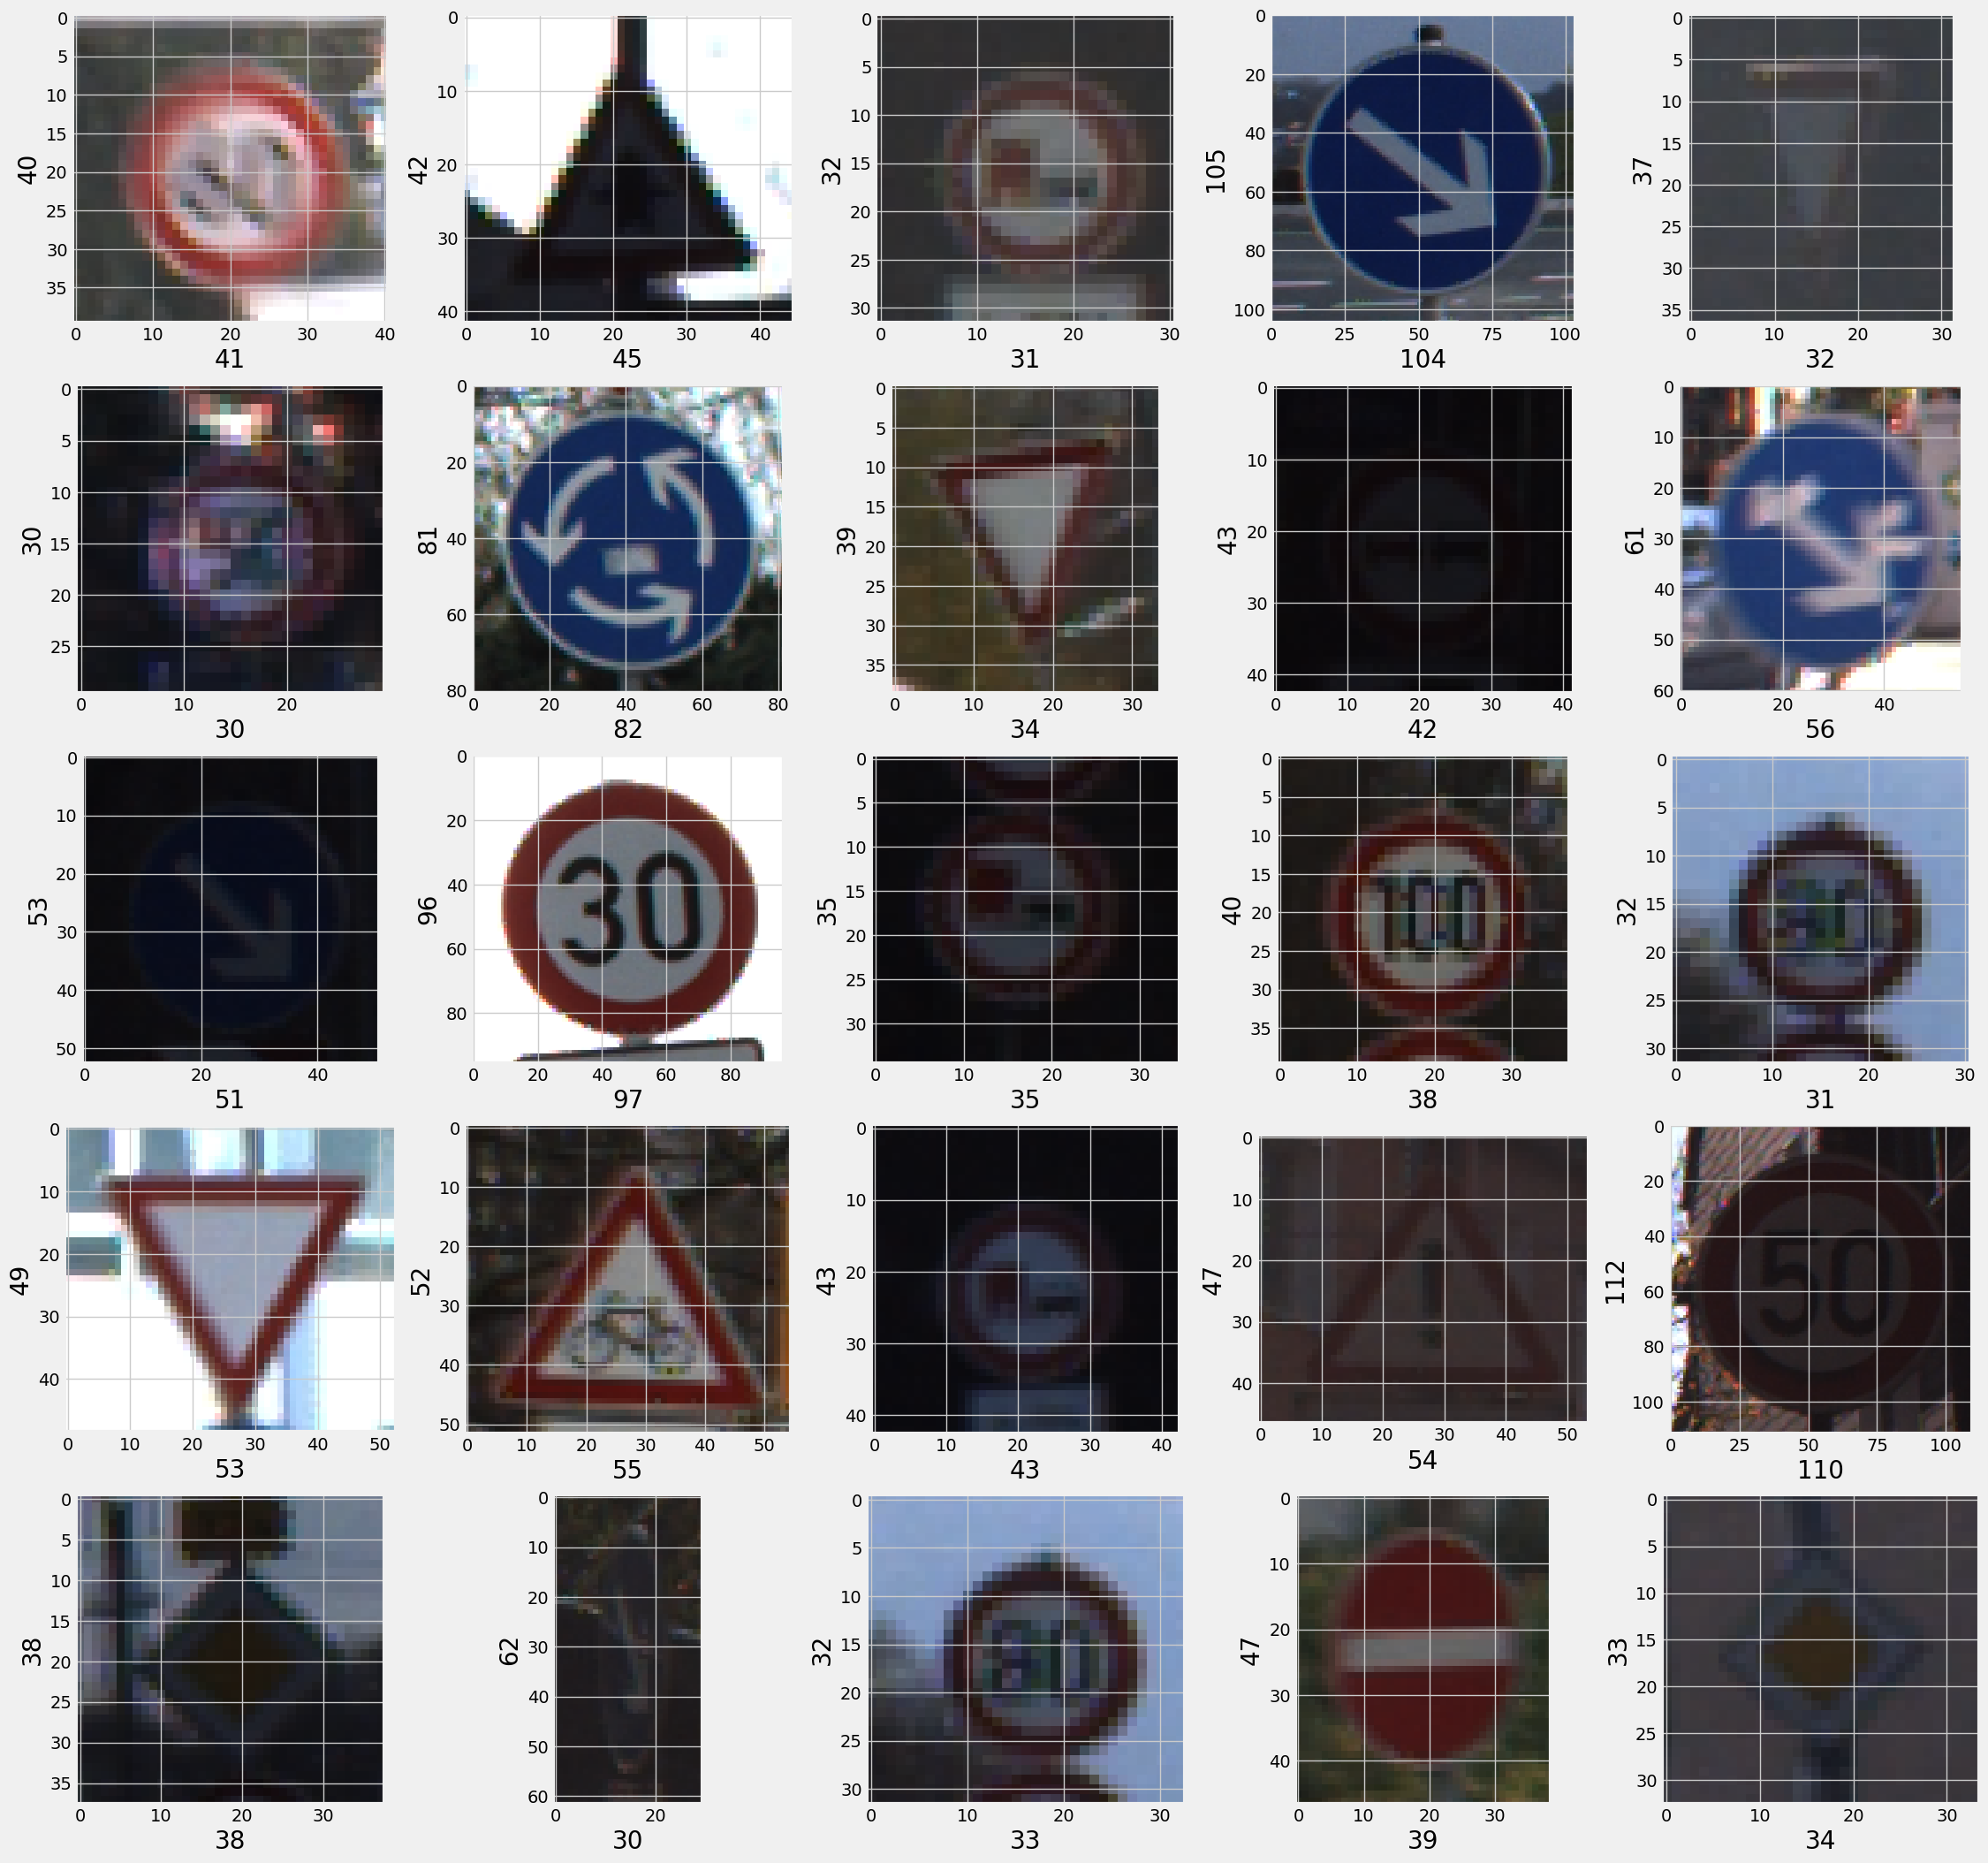

In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from keras.models import load_model

np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')
import random
from matplotlib.image import imread
path = '/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign'
test = pd.read_csv(path + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = path + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    # plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [5]:
image_data = []
image_labels = []
dir = "/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign" 
for i in range(43):
    path = os.path.join(dir,'Train')
    class_path = os.path.join(path, str(i))
    images = os.listdir(class_path)

    for img in images:
        try:
            image = cv2.imread(class_path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((30, 30))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


In [6]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val, 43)

print(y_train.shape)
print(y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)
(27446, 43)
(11763, 43)


In [8]:
from tensorflow.keras.optimizers.legacy import Adam

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),

    keras.layers.Dense(43, activation='softmax')
])

lr = 0.001
epochs = 40
opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [9]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/4
858/858 [==============================] - 105s 121ms/step - loss: 1.0663 - accuracy: 0.7108 - val_loss: 0.1265 - val_accuracy: 0.9623
Epoch 2/4
858/858 [==============================] - 106s 124ms/step - loss: 0.1685 - accuracy: 0.9491 - val_loss: 0.0219 - val_accuracy: 0.9940
Epoch 3/4
858/858 [==============================] - 105s 122ms/step - loss: 0.0934 - accuracy: 0.9721 - val_loss: 0.0115 - val_accuracy: 0.9969
Epoch 4/4
858/858 [==============================] - 102s 119ms/step - loss: 0.0601 - accuracy: 0.9824 - val_loss: 0.0070 - val_accuracy: 0.9977


In [ ]:
model.save('my_model_new.h5')

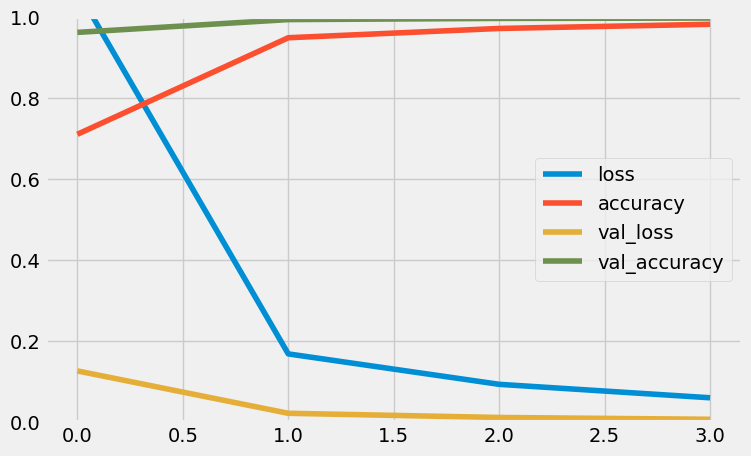

In [10]:
model = load_model('/content/my_model_new.h5')
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [11]:
test = pd.read_csv('/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test
predictions = model.predict(X_test)
pred = np.argmax(predictions, axis=-1)

# pred = model.predict_classes(X_test)

#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 11s 28ms/step
Test Data accuracy:  56.888361045130644


In [12]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.09      0.98      0.16        60
           1       1.00      0.72      0.83       720
           2       1.00      0.31      0.47       750
           3       0.80      0.04      0.08       450
           4       1.00      0.40      0.57       660
           5       1.00      0.00      0.01       630
           6       0.00      0.00      0.00       150
           7       1.00      0.67      0.80       450
           8       1.00      0.00      0.00       450
           9       1.00      0.05      0.09       480
          10       1.00      0.22      0.36       660
          11       0.70      0.86      0.77       420
          12       0.96      0.82      0.88       690
          13       1.00      0.98      0.99       720
          14       0.97      0.96      0.97       270
          15       0.78      0.74      0.76       210
          16       0.04      1.00      0.08       150
          17       0.79    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
class_labels = [
  'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)',
  'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)',
  'End of speed limit (80km/h)','Speed limit (100km/h)','Speed limit (120km/h)',
  'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection',
  'Priority road', 'Yield', 'Stop', 'No vehicles','Veh > 3.5 tons prohibited',
  'No entry', 'General caution', 'Dangerous curve left','Dangerous curve right',
  'Double curve', 'Bumpy road', 'Slippery road','Road narrows on the right',
  'Road work', 'Traffic signals', 'Pedestrians','Children crossing',
  'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
  'End speed + passing limits', 'Turn right ahead', 'Turn left ahead',
  'Ahead only','Go straight or right', 'Go straight or left', 'Keep right',
  'Keep left','Roundabout mandatory', 'End of no passing', 'End no passing veh > 3.5 tons'
]

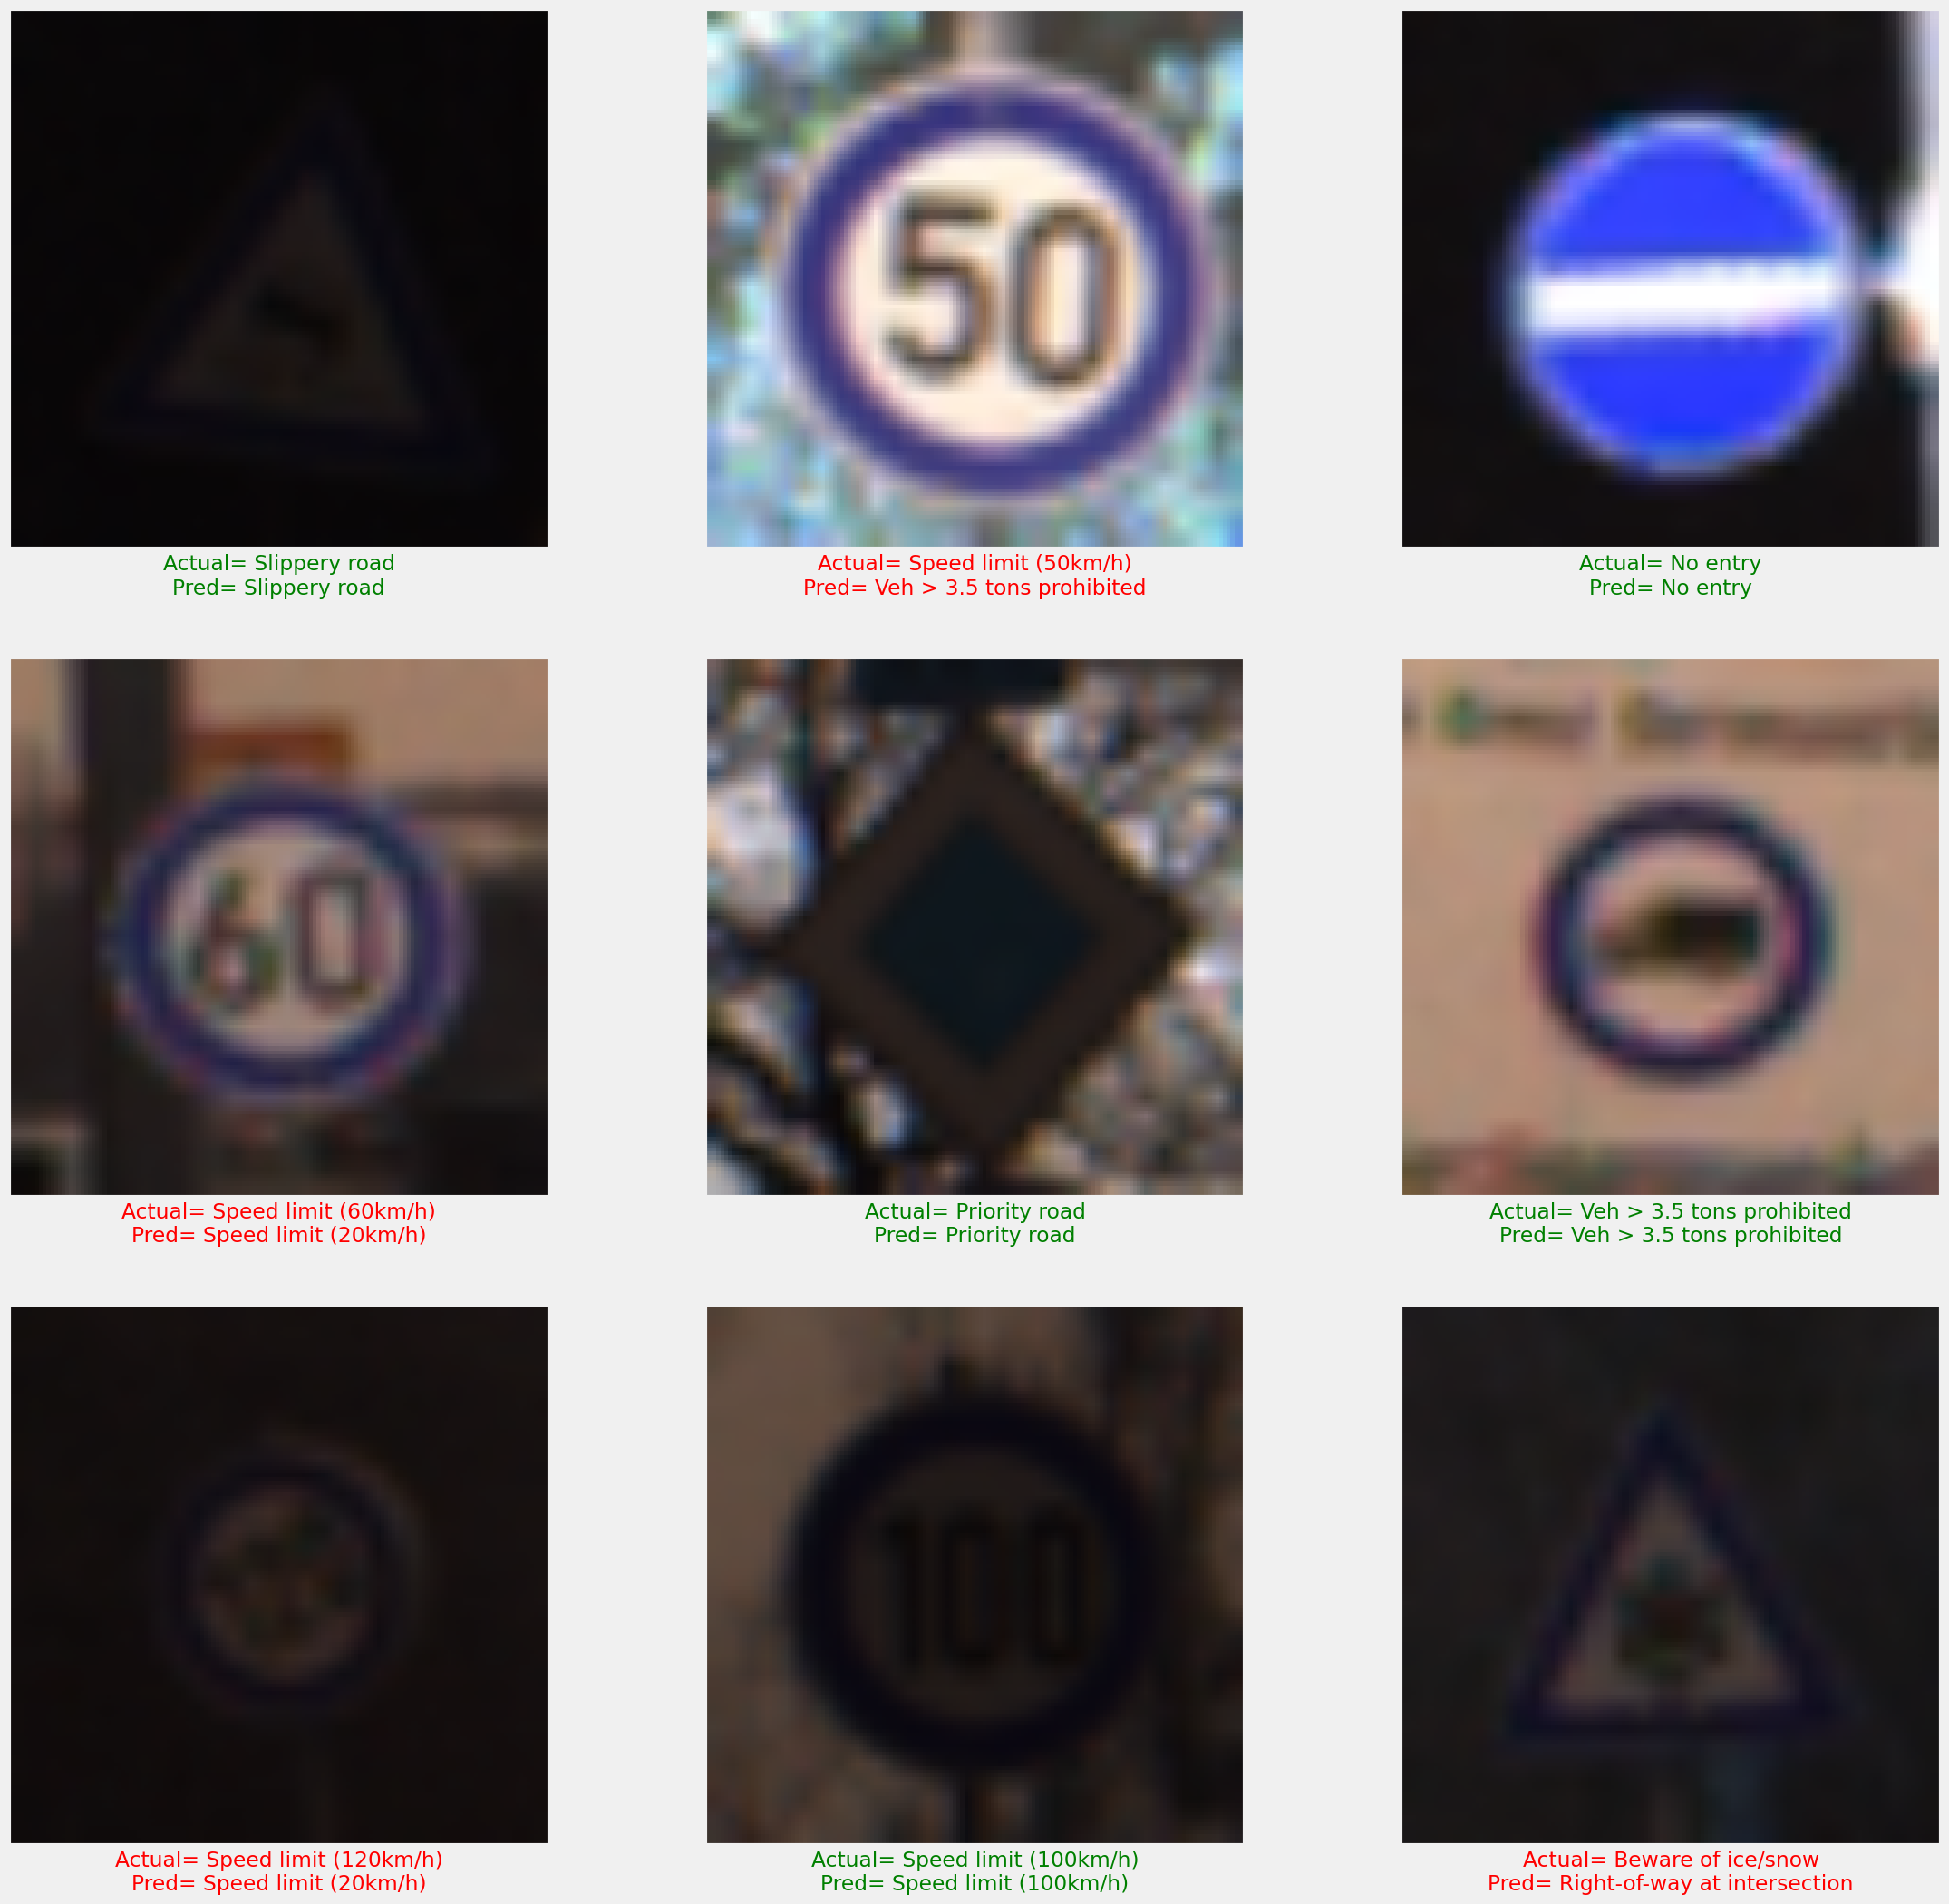

In [15]:
plt.figure(figsize = (25, 25))

start_index = 33
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual= {}\nPred= {}'.format(class_labels[labels[start_index+i]], class_labels[pred[start_index+i]]), color=col)
    resized_img = cv2.resize(X_test[start_index + i], (144, 144))
    plt.imshow(resized_img)
plt.show()

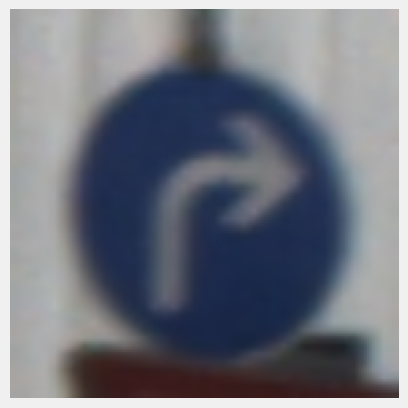

Prediction 
 Turn right ahead
Actual 
 Turn right ahead   33


In [16]:
img = cv2.imread('/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign/Test/00099.png')
resized_img = cv2.resize(img, (144, 144))
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
idx = 99
print('Prediction \n',class_labels[pred[idx]])
print('Actual \n',class_labels[labels[idx]], ' ' ,labels[idx])